In [1]:
import sys, os, pygmt, importlib, re, time, glob
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox, SeaIceToolboxManager
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from tqdm                 import tqdm        
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display      import Image, HTML, Video
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")

In [47]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

In [2]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SIA_dict    = {}
SIV_dict    = {}
G_CMEMS     = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p083_grid.nc")
x_dist      = G_CMEMS['e1t'].load()
y_dist      = G_CMEMS['e2t'].load()
ORAS_A      = x_dist * y_dist
ORAS_A_SH   = ORAS_A.isel(latitude=slice(0,1020))
ORAS_A_da   = xr.DataArray(ORAS_A_SH.values, coords = ORAS_A_SH.coords, dims = ORAS_A_SH.dims)

In [3]:
years = range(1994, 2000)
def compute_ORAS_sia_siv_sit(P_nc, A_da):
    ds = xr.open_dataset(P_nc, engine="h5netcdf").isel(latitude=slice(0, 1020))[["siconc", "sithick"]].astype("float32")
    mask = ds["siconc"] > 0.15
    sic  = xr.where(mask, ds["siconc"], 0.0)
    hi   = xr.where(mask, ds["sithick"], 0.0)
    area = A_da.astype("float32")
    sia = (sic * area).sum(("latitude", "longitude")) / 1e12
    siv = (sic * hi * area).sum(("latitude", "longitude")) / 1e12
    sit = siv/sia
    return sia, siv, sit
    
sias, sivs, sits = [], [], []
for yr in years:
    P_ = f"/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/{yr}0101_{yr}1231_CMEMS_0p083_org.nc"
    print("working on", P_)
    sia, siv, sit = compute_ORAS_sia_siv_sit(P_, ORAS_A_da)
    sias.append(sia.compute())
    sivs.append(siv.compute())
    sits.append(sit.compute())
# Concatenate along time (they already have daily time coords)
SIA = xr.concat(sias, dim="time")
SIV = xr.concat(sivs, dim="time")
SIT = xr.concat(sits, dim="time")
# Optional: sort time in case any year has inclusive endpoints
SIA = SIA.sortby("time")
SIV = SIV.sortby("time")
SIT = SIT.sortby("time")
# One compute (or write to disk)
# ts = xr.Dataset({"SIA": SIA, "SIV": SIV})
# ts.to_zarr("/scratch/$PROJECT/$USER/CMEMS_SIA_SIV_1994-1999.zarr", mode="w", consolidated=True)
#ts = xr.Dataset({"SIA": SIA, "SIV": SIV})

working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19940101_19941231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19950101_19951231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19960101_19961231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19970101_19971231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19980101_19981231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19990101_19991231_CMEMS_0p083_org.nc


In [4]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)

2025-09-09 08:00:26,542 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-09 08:00:26,623 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-09 08:00:26,624 - INFO - hemisphere initialised: SH
2025-09-09 08:00:26,626 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-09 08:00:26,641 - INFO -  self.ice_class defined as FI_BT
2025-09-09 08:00:26,642 - INFO - --- SeaIceToolbox Summary ---
2025-09-09 08:00:26,644 - INFO - Simulation Name     : elps-min
2025-09-09 08:00:26,644 - INFO - Analysis Start Date : 1994-01-01
2025-09-09 08:00:26,646 - INFO - Analysis End Date   : 1999-12-31
2025-09-09 08:00:26,646 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-09 08:00:26,647 - INFO - Speed Type(s)       : BT
2025-09-09 08:00:26,649 - INFO - Ice T

In [5]:
SIA_dict, SIV_dict, SIT_dict = {}, {}, {}
NSIDC_ts = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = {'SIA' : NSIDC_ts['SIA'].sel(time=slice(dt0_str,dtN_str))}

2025-09-09 08:00:26,669 - INFO - **loading** previously created NSIDC time series zarr file /g/data/gv90/da1339/SeaIce/NSIDC/G02202_V4/south/daily/zarr


In [6]:
SIT_dict = {}
SIA_dict['ORAS'] = {'SIA' : SIA}
SIV_dict['ORAS'] = {'SIV' : SIV}
SIT_dict['ORAS'] = {'SIT' : SIT}

In [7]:
def sia_siv_for_year(sim_name: str, yr: int):
    dt0, dtN = f"{yr}-01-01", f"{yr}-12-31"
    SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0, dtN_str=dtN)
    so = SI_tools.load_cice_zarr(slice_hem=True, variables=["aice","hi","tarea"])
    sic = so["aice"]                          # [time, j, i]
    hi  = so["hi"]                            # [time, j, i]
    A   = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sia = SI_tools.compute_hemisphere_ice_area(sic, A, ice_area_scale=SI_tools.SIC_scale)
    siv = SI_tools.compute_hemisphere_ice_volume(sic, hi, A)
    sia = sia.rename("SIA")
    siv = siv.rename("SIV")
    return sia, siv

for sim_name in ["elps-min","notensnogi","ry93","AOM2-ERA5"]:
    sias, sivs = [], []
    for yr in range(1994, 2000):
        sia, siv = sia_siv_for_year(sim_name, yr)
        sias.append(sia)
        sivs.append(siv)
    SIA = xr.concat(sias, dim="time").sortby("time")
    SIV = xr.concat(sivs, dim="time").sortby("time")
    # keep it lazy until you need the values:
    # ds = xr.Dataset({"SIA": SIA, "SIV": SIV}).compute()
    ds = xr.Dataset({"SIA": SIA, "SIV": SIV})
    # if you need the original dict layout:
    SIA_dict[sim_name] = {"SIA": ds["SIA"]}
    SIV_dict[sim_name] = {"SIV": ds["SIV"]}
    

2025-09-09 08:00:26,956 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-09 08:00:26,982 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-09 08:00:26,983 - INFO - hemisphere initialised: SH
2025-09-09 08:00:26,984 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-09 08:00:26,986 - INFO -  self.ice_class defined as FI_BT
2025-09-09 08:00:26,987 - INFO - --- SeaIceToolbox Summary ---
2025-09-09 08:00:26,987 - INFO - Simulation Name     : elps-min
2025-09-09 08:00:26,989 - INFO - Analysis Start Date : 1994-01-01
2025-09-09 08:00:26,989 - INFO - Analysis End Date   : 1994-12-31
2025-09-09 08:00:26,991 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-09 08:00:26,991 - INFO - Speed Type(s)       : BT
2025-09-09 08:00:26,992 - INFO - Ice T

In [ ]:
SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
SI_tools.pygmt_timeseries(SIA_dict, 
                          comp_name   = "SH",
                          primary_key = "SIA",
                          climatology = False,
                          ylabel      = "Sea Ice Area (@[1\\times10^6\\ \\mathrm{km}^2@[)",
                          ylim        = [0,20],
                          ytick_pri   = 2,
                          ytick_sec   = 1,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6c")

In [ ]:
SI_tools.pygmt_timeseries(SIV_dict, 
                          comp_name   = "SH",
                          primary_key = "SIV",
                          climatology = True,
                          ylabel      = "Sea Ice Volume (@[1\\times10^6\\ \\mathrm{km}^3@[)",
                          ylim        = [0,21],
                          ytick_pri   = 2,
                          ytick_sec   = 1,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6c")

In [ ]:
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
for item in ["notensnogi"]:#Path(SI_tools.D_dict["AFIM_out"]).iterdir():
    # if item.name in skip_names:
    #     continue
    sim_name = item#.name
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                       dtN_str  = dtN_str,
                                       sim_name = sim_name)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIA",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = True)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIT",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIS",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)

In [ ]:
#AF2020 = xr.open_zarr(SI_tools.AF_FI_dict['P_AF2020_reG_zarr'], consolidated=False)
D_obs   = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs  = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs  = xr.open_mfdataset(P_orgs, engine='netcdf4', combine='by_coords')
lat_c   = FI_obs['latitude'].isel(time=0)
lon_c   = FI_obs['longitude'].isel(time=0)
FI_mask = xr.where(FI_obs['Fast_Ice_Time_series'] >= 4, 1.0, 0.0)

In [ ]:
def print_scalar_vars(ds, label=""):
    """Print scalar variables and their values from an xarray.Dataset."""
    print(f"\nScalar variables in dataset {label}:\n" + "-"*40)
    for var in ds.data_vars:
        if ds[var].dims == ():
            val = ds[var].values.item()  # extract scalar value
            print(f"{var:30s}: {val:.4f}")
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "FIA_and_FIP_figs.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name)
AF2020      = xr.open_dataset(SI_tools.AF_FI_dict['P_AF2020_FIA'])["AF2020"]
comp_name   = "Cstar-comparison"
comp_sims   = ["Cstar-min","Cstar-max","elps-min","gi-mid"]
sim_names   = ["Cstar-min","Cstar-max","Pstar-min","Pstar-max","elps-max","elps-mid","elps-min","elps-ext",
               "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi","ktens-nil","ktens-min","ktens-max","ktens-ext"]
FIA_dict    = {'AF2020'     : {'FIA' : AF2020}}
FIT_dict    = {}
FIS_dict    = {}
FIMAR_dict  = {}
FIMVR_dict  = {}
FITAR_dict  = {}
FITVR_dict  = {}
for sim_name in comp_sims:
    FI_bn_mets = xr.open_zarr(Path('/','g','data','gv90','da1339','afim_output',sim_name,'zarr','ispd_thresh_5.0e-4',"FI_BT_bin_mets.zarr"))
    FIA_dict[sim_name]   = {'FIA'   : FI_bn_mets['FIA']}
    FIT_dict[sim_name]   = {'FIT'   : FI_bn_mets['FIT']}
    FIS_dict[sim_name]   = {'FIS'   : FI_bn_mets['FIS']}
    FIMAR_dict[sim_name] = {'FIMAR' : FI_bn_mets['FIMAR']}
    FIMVR_dict[sim_name] = {'FIMVR' : FI_bn_mets['FIMVR']}
    FITAR_dict[sim_name] = {'FITAR' : FI_bn_mets['FITAR']}
    FITVR_dict[sim_name] = {'FITVR' : FI_bn_mets['FITVR']}

In [ ]:
SI_tools.pygmt_timeseries(FIA_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIA",
                          climatology = True,
                          ylabel      = "Fast Ice Area (@[1\\times10^3\\ \\mathrm{km}^2@[)",
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIT_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIT",
                          climatology = True,
                          ylabel      = "Fast Ice Thickness (m)",
                          ylim        = [1,7],
                          ytick_pri   = 1,
                          ytick_sec   = .5,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIS_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIS",
                          climatology = True,
                          ylabel      = "Fast Ice Strength (mPa)",
                          ylim        = [0,1500],
                          ytick_pri   = 100,
                          ytick_sec   = 50,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMAR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Area Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMVR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMVR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Volume Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FITAR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Area Rate (m/s)",
                          ylim        = [-0.5,1.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITVR_dict, 
                          comp_name   = comp_name,
                          
                          primary_key = "FITVR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Volume Rate (m/s)",
                          ylim        = [-3.5,3.5],
                          ytick_pri   = .5,
                          ytick_sec   = .25,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")

In [ ]:
def plot_taylor_diagram(ds,
                        sims_include=None,
                        top_k=None,
                        var_prefix='SIA',
                        normalize=True,
                        add_rmsd_contours=True):
    sim_names = ds.simulation.values
    corr  = ds[f'{var_prefix}_skills_Corr'].values
    std_m = ds[f'{var_prefix}_skills_SD_Model'].values
    std_o = ds[f'{var_prefix}_skills_SD_Obs'].values
    rmsd  = ds[f'{var_prefix}_skills_RMSE'].values

    # Optional filtering: by name
    if sims_include is not None:
        mask = np.isin(sim_names, sims_include)
        sim_names = sim_names[mask]
        corr = corr[mask]
        std_m = std_m[mask]
        std_o = std_o[mask]
        rmsd = rmsd[mask]

    # Optional filtering: by top_k
    elif top_k is not None:
        sort_idx = np.argsort(rmsd)
        sim_names = sim_names[sort_idx][:top_k]
        corr = corr[sort_idx][:top_k]
        std_m = std_m[sort_idx][:top_k]
        std_o = std_o[sort_idx][:top_k]
        rmsd = rmsd[sort_idx][:top_k]

    # Normalize standard deviations
    if normalize:
        std_m_norm = std_m / std_o
        std_o_norm = np.ones_like(std_o)
    else:
        std_m_norm = std_m
        std_o_norm = std_o
    
    # Compute angle (theta) from correlation
    theta = np.arccos(corr)

    # Compute centered RMSD (optional but nice to verify)
    rmsd_c = np.sqrt(std_m_norm**2 + std_o_norm**2 - 2 * std_m_norm * std_o_norm * corr)

    # Start plotting
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, polar=True)

    # Plot reference point
    ax.plot(0, 1.0, 'ko', label='Obs (normalized)' if normalize else 'Obs')

    # Plot simulations
    for i, name in enumerate(sim_names):
        ax.plot(theta[i], std_m_norm[i], 'o', label=str(name))

    # Optional: Add RMSD contours
    if add_rmsd_contours:
        rs, ts = np.meshgrid(np.linspace(0, max(std_m_norm)*1.2, 300), np.linspace(0, np.pi/2, 300))
        corr_grid = np.cos(ts)
        rmsd_grid = np.sqrt(1 + rs**2 - 2 * rs * corr_grid)
        cs = ax.contour(ts, rs, rmsd_grid, levels=np.arange(0.2, 2.5, 0.2),
                        colors='gray', linewidths=0.5, linestyles='dotted')
        ax.clabel(cs, inline=1, fontsize=8, fmt="%.1f")
    # sc = ax.scatter(theta, std_m_norm, c=rmsd_c, cmap='viridis', s=80)
    # cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    # cbar.set_label('Centered RMSD')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('E')
    corr_levels = [0.90, 0.92, 0.94, 0.96, 0.98, 0.99, 1.0]
    ax.set_thetagrids(np.degrees(np.arccos(corr_levels)), labels=[f"{c:.2f}" for c in corr_levels])
    # ax.set_thetagrids(np.degrees(np.arccos(np.linspace(0.1, 1.0, 10))), 
    #                   labels=[f"{r:.2f}" for r in np.linspace(0.9, 0.0, 10)])
    ax.set_title(f"Taylor Diagram: {var_prefix} Skill", fontsize=14)
    ax.set_rlabel_position(135)
    ax.set_rlim(0, max(std_m_norm)*1.1)
    ax.set_thetamin(0)     # keep full angular range (or restrict more tightly)
    ax.set_thetamax(30)    # zoom into the high-correlation area
    ax.legend(loc='lower left')#, bbox_to_anchor=(1.4, 1.15))
    plt.tight_layout()
    plt.show()

In [ ]:
plot_taylor_diagram(ds, sims_include=["CMEMS-ORAS","AOM2-ERA5","ndte-min","ndte-max","elps-min","gi-nil-def"], var_prefix='SIA')

In [ ]:
def plot_skill_bar(ds, metric='SIA_skills_RMSE', title='RMSE (SIA)', sort=True):
    vals = ds[metric].values
    names = ds.simulation.values

    if sort:
        idx = np.argsort(vals)
        vals = vals[idx]
        names = names[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(names, vals)
    plt.ylabel(title)
    plt.xticks(rotation=90)
    plt.title(f"{title} by Simulation")
    plt.tight_layout()
    plt.show()
plot_skill_bar(ds, metric='SIA_skills_RMSE', title='SIA RMSE')
plot_skill_bar(ds, metric='SIA_skills_Corr', title='SIA Correlation')

In [ ]:
def plot_all_seasonal_stats(ds):
    # Filter variables that match seasonal SIA or SIV stats
    seasonal_vars = [v for v in ds.data_vars if re.match(r'(SIA|SIV)_season_.*_(Mean|Std)$', v)]
    
    # Group by base metric (remove trailing _Mean or _Std)
    metric_groups = {}
    for var in seasonal_vars:
        base = re.sub(r'_(Mean|Std)$', '', var)
        if base not in metric_groups:
            metric_groups[base] = {}
        if var.endswith('Mean'):
            metric_groups[base]['mean'] = var
        elif var.endswith('Std'):
            metric_groups[base]['std'] = var

    sim_names = ds.simulation.values

    for base, pair in metric_groups.items():
        mean_vals = ds[pair['mean']].values
        std_vals = ds[pair['std']].values if 'std' in pair else None

        # Sort simulations by mean value
        idx = np.argsort(mean_vals)
        mean_sorted = mean_vals[idx]
        names_sorted = sim_names[idx]
        if std_vals is not None:
            std_sorted = std_vals[idx]
        
        # Plot
        plt.figure(figsize=(10, 5))
        if std_vals is not None:
            plt.errorbar(np.arange(len(names_sorted)), mean_sorted, yerr=std_sorted, fmt='o-', capsize=3)
        else:
            plt.plot(np.arange(len(names_sorted)), mean_sorted, 'o-')

        plt.xticks(np.arange(len(names_sorted)), names_sorted, rotation=90)
        plt.title(base.replace("_", " "))
        plt.tight_layout()
        plt.show()
        

In [ ]:
plot_all_seasonal_stats(ds)

In [ ]:
def sit_for_year(sim_name: str, yr: int):
    dt0, dtN = f"{yr}-01-01", f"{yr}-12-31"
    SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0, dtN_str=dtN)
    so = SI_tools.load_cice_zarr(slice_hem=True, variables=["aice","hi","tarea"])
    sic = so["aice"]                          # [time, j, i]
    hi  = so["hi"]                            # [time, j, i]
    A   = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sit = SI_tools.compute_hemisphere_ice_thickness(sic, hi, A)
    sit = sit.rename("SIT")
    return sit

for sim_name in ["elps-min","notensnogi","ry93","AOM2-ERA5"]:
    sits = []
    for yr in range(1994, 2000):
        sit = sit_for_year(sim_name, yr)
        sits.append(sit)
    SIT = xr.concat(sits, dim="time").sortby("time")
    ds = xr.Dataset({"SIT": SIT})
    SIT_dict[sim_name] = {"SIT": ds["SIT"]} 

2025-09-09 08:06:00,041 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-09 08:06:00,130 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-09 08:06:00,131 - INFO - hemisphere initialised: SH
2025-09-09 08:06:00,133 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-09 08:06:00,136 - INFO -  self.ice_class defined as FI_BT
2025-09-09 08:06:00,136 - INFO - --- SeaIceToolbox Summary ---
2025-09-09 08:06:00,137 - INFO - Simulation Name     : elps-min
2025-09-09 08:06:00,139 - INFO - Analysis Start Date : 1994-01-01
2025-09-09 08:06:00,140 - INFO - Analysis End Date   : 1994-12-31
2025-09-09 08:06:00,141 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-09 08:06:00,142 - INFO - Speed Type(s)       : BT
2025-09-09 08:06:00,143 - INFO - Ice T

In [ ]:
paths = SI_tools.build_sea_ice_satellite_paths(dt0_str      = "2002-01-01",
                                               dtN_str      = "2012-12-31",
                                               hemisphere   = "sh",
                                               institutions = ["ESA"],
                                               sensors      = ["envisat"],
                                               levels       = ["L2P"])
area = SI_tools.ease2_sh_50km()
env_sit = SI_tools.l2p_to_daily_grid_pyresample(paths, hem="sh", area_def=area, roi_km=45, neighbours=24, gaussian_sigma_km=None )
paths  = SI_tools.build_sea_ice_satellite_paths(dt0_str      = "2010-01-01",
                                                dtN_str      = "2017-12-31",
                                                hemisphere   = "sh",
                                                institutions = ["ESA"],
                                                sensors      = ["cryosat2"],
                                                levels       = ["L2P"])
area   = SI_tools.ease2_sh_50km()
cry_sit = SI_tools.l2p_to_daily_grid_pyresample(paths, hem="sh", area_def=area, roi_km=45, neighbours=24, gaussian_sigma_km=None )
both = xr.concat([env_sit['SIT_hem'], cry_sit['SIT_hem']], dim="time").sortby("time")
merged = both.groupby("time").mean()
merged = merged.astype("float32")             # optional: keep float32
merged.name = "SIT_hem"             # keep a nice name
print(merged)

In [ ]:
paths  = SI_tools.build_sea_ice_satellite_paths(dt0_str      = "2012-01-01",
                                                dtN_str      = "2023-12-31",
                                                hemisphere   = "sh",
                                                institutions = ["AWI"],
                                                sensors      = ["cryosat2"],
                                                levels       = ["l2p_release"])
area   = SI_tools.ease2_sh_50km()
cry_awi = SI_tools.l2p_to_daily_grid_pyresample(paths, hem="sh", area_def=area, roi_km=45, neighbours=24, gaussian_sigma_km=None )

2025-09-08 11:35:30,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 6.52 GiB


In [ ]:
cry_awi['SIT_hem'].plot()

In [21]:
ds_mo = SI_tools.make_monthly_gridded_SIT_L3(dt0_str       = "2010-01-01",
                                             dtN_str       = "2023-12-31",
                                             hemisphere    = "sh",
                                             institutions  = ["ESA","AWI"],
                                             levels        = ["L3C","l3cp_release"],
                                             sensors       = ["cryosat2","envisat","sentinel3a","sentinel3b"],
                                             mask_strategy = "both",
                                             sic_thresh_percent = 15.0,
                                             include_snow       = True,
                                             include_flags      = True,
                                             prefer             = "last")

In [26]:
#ds_mo['SIT_hem']
SIT_dict['ESA-CCI'] = { 'SIT' : merged }

In [4]:
sep22 = SI_tools.make_daily_gridded_SIT(dt0_str      = "2022-09-01",
                                        dtN_str      = "2022-09-30",
                                        hemisphere   = "sh",
                                        institutions = ["AWI"],
                                        levels       = ["l2p_release"],
                                        sensors      = ["cryosat2"])

/home/581/da1339/AFIM/src/AFIM/src/sea_ice_observations.py:967: UserWarning: Possible more than 16 neighbours within 75000.0 m for some data points
  valid_in_idx, valid_out_idx, index_array, dist_array = kd_tree.get_neighbour_info(


In [5]:
#print(sep22['SIT_hem'].values)
sep22

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 30, y: 216, x: 216)
Coordinates:
  * time         (time) datetime64[ns] 240B 2022-09-01T12:00:00 ... 2022-09-3...
  * y            (y) int64 2kB 0 1 2 3 4 5 6 7 ... 209 210 211 212 213 214 215
  * x            (x) int64 2kB 0 1 2 3 4 5 6 7 ... 209 210 211 212 213 214 215
    lon          (y, x) float64 373kB -45.0 -44.73 -44.46 ... 135.5 135.3 135.0
    lat          (y, x) float64 373kB -16.82 -17.22 -17.61 ... -17.22 -16.82
Data variables:
    SIT          (time, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    SIT_unc      (time, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    u_cell       (time, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    n_cell       (time, y, x) int32 6MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SIT_hem      (time) float32 120B 1.787 1.628 1.738 ... 1.67 1.786 1.606
    SIT_hem_unc  (time) float32 120B 0.008996 0.008445 ... 0.009183 0.008667
    SIT_hem_u    (time) float32 120B 1.309 1.271 1.306 ... 1.281 1.317 1.267
    SIT_hem_n    (time) int32 120B 26273 28124 26595 28226 ... 27853 26188 27113
Attributes:
    note:     L2P swath resampled to target grid via pyresample neighbour inf...

In [7]:
sep22_mo = SI_tools.make_monthly_gridded_SIT_L3(dt0_str="2012-01-01",
                                             dtN_str="2023-12-31",
                                             hemisphere="sh",
                                             institutions=["AWI"],
                                             levels=["l3cp_release"],
                                             sensors=["cryosat2"],
                                             mask_strategy=None,
                                             sic_thresh_percent=15.0,
                                             include_snow=False,
                                             include_flags=False,
                                             prefer="last")


In [12]:
da = sep22_mo["SIT_hem"]                 # your DataArray (time: monthly)
sep = da.where(da.time.dt.month == 9, drop=True)

print(sep)            # shows times (every September) + values
print(sep.values)     # just the numbers
print(sep.time.values)

<xarray.DataArray 'SIT_hem' (time: 12)> Size: 48B
array([1.6367632, 1.691038 , 1.6479415, 1.6323953, 1.5502418, 1.5140172,
       1.5047282, 1.5095456, 1.5152804, 1.5282676, 1.529649 , 1.5082812],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 96B 2012-09-01 2013-09-01 ... 2023-09-01
[1.6367632 1.691038  1.6479415 1.6323953 1.5502418 1.5140172 1.5047282
 1.5095456 1.5152804 1.5282676 1.529649  1.5082812]
['2012-09-01T00:00:00.000000000' '2013-09-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2017-09-01T00:00:00.000000000'
 '2018-09-01T00:00:00.000000000' '2019-09-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2021-09-01T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2023-09-01T00:00:00.000000000']


In [6]:
W_cell = sep22.n_cell.where(np.isfinite(sep22.SIT))
num = (sep22.SIT * W_cell).sum("time")
den = W_cell.sum("time")
SIT_month = num / den  # cellwise monthly mean, collate-like

# Hemispheric monthly mean (area-weighted)
Warea = np.cos(np.deg2rad(sep22.lat))
SIT_hem_likeL3C = (SIT_month * Warea).where(np.isfinite(SIT_month)).sum(("y","x")) / \
                  Warea.where(np.isfinite(SIT_month)).sum(("y","x"))

# Optional: concentration-weighted hemispheric mean (if SIC on the grid)
SICm = (sep22.SIC.where(np.isfinite(sep22.SIT)).sum("time") /
        sep22.SIC.notnull().sum("time"))  # or composite SIC carefully
SIT_wgt_likeL3C = (SIT_month * SICm).sum(("y","x")) / SICm.sum(("y","x"))

AttributeError: 'Dataset' object has no attribute 'SIC'

In [ ]:
#print(ds.time.values)
idx = 270
import matplotlib.pyplot as plt
im = np.ma.masked_invalid(ds_cry["SIT"].isel(time=idx).values)
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="lightgray")  # NaNs
plt.imshow(im, origin="lower", cmap=cmap, vmin=0, vmax=4)
plt.colorbar(label="sea ice thickness [m]")
plt.title(str(pd.to_datetime(ds.time.values[idx])))
plt.show()

NameError: name 'ds_cry' is not defined

In [ ]:
ds_cci = xr.open_dataset(Path(os.path.expanduser("~/AFIM_archive/ESA_CCI"),"SIT_ESA-CCI_daily_climatology_2002-2012.nc")
SIT_dict["ESA-CCI"] =  {"SIT": ds_cci["SIT"]}
SIT_dict

2025-09-09 14:56:27,211 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-09-09 14:57:05,671 - INFO - Dask Client Connected
  Dashboard      : /proxy/35923/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-09-09 14:57:05,675 - INFO - hemisphere initialised: SH
2025-09-09 14:57:05,677 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-09 14:57:05,689 - INFO -  self.ice_class defined as FI_BT
2025-09-09 14:57:05,693 - INFO - --- SeaIceToolbox Summary ---
2025-09-09 14:57:05,694 - INFO - Simulation Name     : elps-min
2025-09-09 14:57:05,696 - INFO - Analysis Start Date : 1994-01-01
2025-09-09 14:57:05,696 - INFO - Analysis End Date   : 1999-12-31
2025-09-09 14:57:05,698 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-09 14:57:05,699 - INFO - Speed Type(s)       : BT
2025-09-09 14:57:05,701 - INFO - Ice 

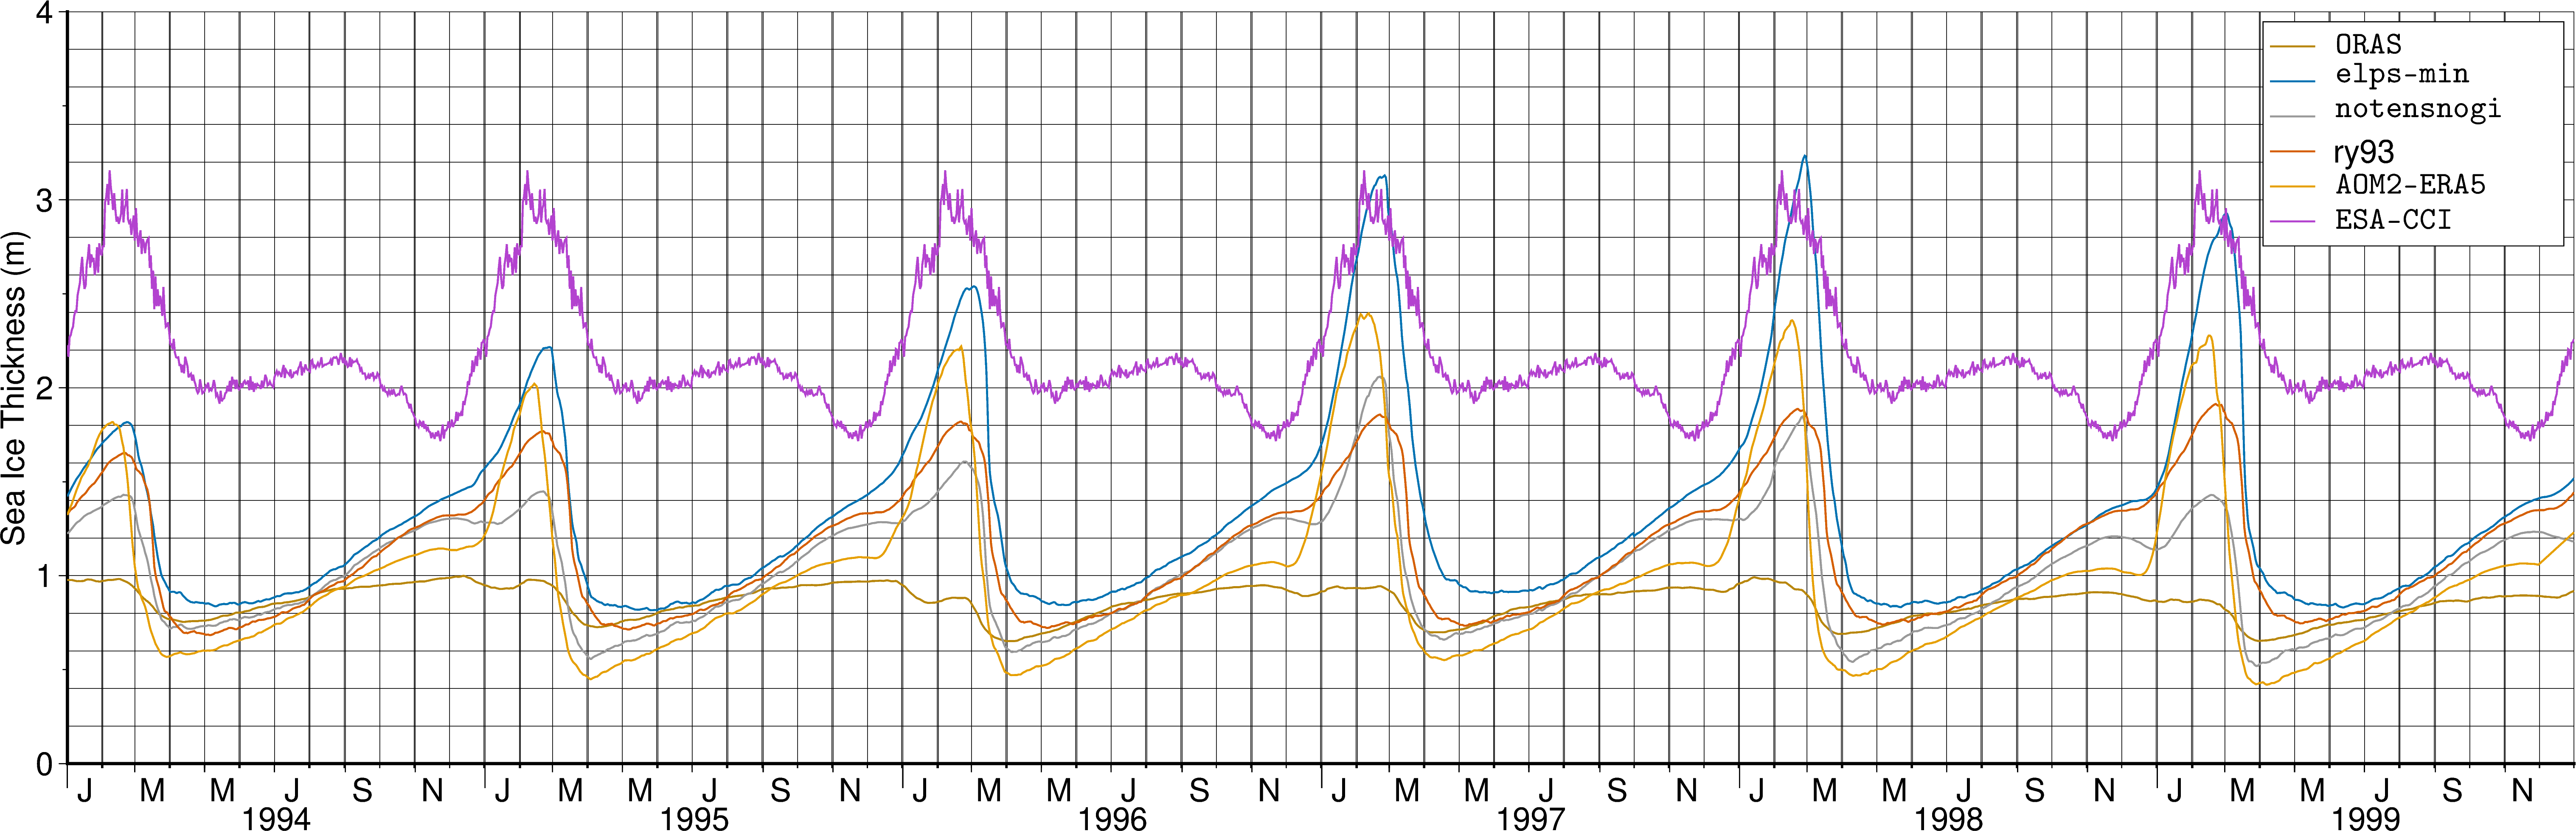

In [49]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
SI_tools.pygmt_timeseries(SIT_dict,
                          comp_name   = "SH",
                          primary_key = "SIT",
                          climatology = False,
                          ylabel      = "Sea Ice Thickness (m)",
                          ylim        = [0, 4],
                          ytick_pri   = 1,
                          ytick_sec   = .5,
                          show_fig    = True,
                          legend_pos  = "JTR+jTR+o0.2c+w6c",
                          repeat_clim_keys = "ESA-CCI",
                          clip_x_axis = True)

In [ ]:
lon_bins    = np.arange(-180, 181, 0.25)
lat_bins    = np.arange(-90, -49.75, 0.25)
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
# define the directory to search for download files
D_search = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh")
# recursively search the sub-directory for files that match
F_search = "ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-*-fv2.0.nc"
P_found  = sorted(D_search.rglob(F_search))
print(f"the number of found files = {len(P_found)}")
# open all the files using mfdataset ... this will use about 10GB of memory
SIT      = {}
sit_list = []
for f in tqdm(P_found, desc="Gridding ESA-CCI SIT"):
    ds      = xr.open_dataset(f)
    lon_raw = ds['lon'].values
    lat_raw = ds['lat'].values
    sit_raw = ds['sea_ice_thickness'].values
    valid   = np.isfinite(lon_raw) & np.isfinite(lat_raw) & np.isfinite(sit_raw)
    lon     = lon_raw[valid]
    lat     = lat_raw[valid]
    sit     = sit_raw[valid]
    sit_binned, _, _, _ = binned_statistic_2d(lon, lat, sit, statistic='mean', bins=[lon_bins, lat_bins])
    sit_grid = np.transpose(sit_binned)  # shape: (lat, lon)
    if "time" in ds and ds.time.size > 0:
        time_val = pd.to_datetime(ds.time.values[0]).floor("D")
    else:
        # Fallback: try extracting from filename
        time_str = f.name.split("-")[-2]  # e.g. "20021001"
        time_val = pd.to_datetime(time_str, format="%Y%m%d")
    sit_da   = xr.DataArray(sit_grid[np.newaxis, :, :],
                            dims=("time", "y", "x"),
                            coords={"time": [time_val], "y": lat_centers, "x": lon_centers},
                            name="SIT")
    sit_list.append(sit_da)
ESA_SIT_reG = xr.concat(sit_list, dim='time')
ESA_SIT_reG = ESA_SIT_reG.sel(time=~ESA_SIT_reG.get_index("time").duplicated())
SIT['ESA']  = ESA_SIT_reG.sel(time=slice("2002", "2012")).mean(("x", "y"), skipna=True)
sit_list = []
for i in tqdm(range(len(CICE_SO.time)), desc=f"computing SIT for {afim_name}"):
    hi_t     = CICE_SO['hi'].isel(time=i).load()
    aice_t   = CICE_SO['aice'].isel(time=i).load()
    tarea_t  = CICE_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(CICE_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[afim_name] = xr.concat(sit_list, dim='time')
sit_list = []
for i in tqdm(range(len(AOM2_SO.time)), desc=f"computing SIT for {aom2_name}"):
    hi_t     = AOM2_SO['hi'].isel(time=i).load()
    aice_t   = AOM2_SO['aice'].isel(time=i).load()
    tarea_t  = AOM2_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(AOM2_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[aom2_name] = xr.concat(sit_list, dim='time')
SIT['ESA']     = SIT['ESA'].assign_coords(doy=SIT['ESA'].time.dt.dayofyear)
SIT[afim_name] = SIT[afim_name].assign_coords(doy=SIT[afim_name].time.dt.dayofyear)
SIT[aom2_name] = SIT[aom2_name].assign_coords(doy=SIT[aom2_name].time.dt.dayofyear)
SIT['ESA_clim']= SIT['ESA'].groupby('doy').mean(dim=('time', 'x', 'y'), skipna=True)
SIT[f"{afim_name}_clim"] = SIT[afim_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT[f"{aom2_name}_clim"] = SIT[aom2_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT.to_netcdf(Path(Path.home(),"AFIM_archive",afim_name,"SIT_sh_comps_v2_2002-2012.nc"))
doy_ticks    = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT['ESA_clim']['doy'], SIT['ESA_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT[f'{afim_name}_clim']['doy'], SIT[f'{afim_name}_clim'].values, label=afim_name, lw=2)
plt.plot(SIT[f'{aom2_name}_clim']['doy'], SIT[f'{aom2_mame}_clim'].values, label=aom2_name, lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(SI_tools.D_graph,afim_name,"SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [ ]:
# SIT_comps = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/SIT_elps-min_*.nc")
# print(SIT_comps)
# ESA_SIT = xr.open_dataset("/g/data/gv90/da1339/SeaIce/ESA_CCI/ESA_CCI_L2P_envisat_SH_SIT_SIV_daily.nc")
# print(ESA_SIT)

In [ ]:
dt                         = pd.to_datetime(SIT_comps["time"].values)
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_obs_clim']  = SIT_comps['SIT_obs'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_AOM2_clim'] = SIT_comps['SIT_AOM2'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_CICE_clim'] = SIT_comps['SIT_CICE'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')

In [ ]:
doy_ticks = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT_comps['doy'], SIT_comps['SIT_obs_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_CICE_clim'].values, label="elps-min", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_AOM2_clim'].values, label="AOM2-ERA5", lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(Path.home(),"graphical","AFIM","elps-min", "SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [ ]:
P_ESA_CCI_reG           = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh","reG","ESA_CCI_SIT_regridded.zarr")
ESA_CCI                 = xr.open_zarr(P_ESA_CCI_reG)
dt                      = pd.to_datetime(ESA_CCI["time"].values)
ESA_CCI.coords['doy']   = ('time', dt.dayofyear)
ESA_CCI['ESA_sit_clim'] = ESA_CCI['ESA_sit'].groupby('doy').mean('time')
ESA_CCI['ESA_sit_clim'].sum(dim=['nj','ni']).plot()

In [ ]:
def compute_doy_climatology(da):
    doy = da['time'].dt.dayofyear
    return da.groupby(doy).mean(dim='time', skipna=True)
hi_SO['doy'] = hi_SO.assign_coords(doy=hi_SO['time'].dt.dayofyear)
hi_SO        = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim   = compute_doy_climatology(hi_SO)

sit_CICE_df  = pd.DataFrame({"longitude": CICE_SO.TLON.values.flatten(), "latitude": CICE_SO.TLAT.values.flatten(), "z": hi_SO_clim.isel(dayofyear=180).values.flatten()})
sit_CICE_reG = pygmt.nearneighbor(data=sit_CICE_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_CICE_da  = xr.DataArray(sit_CICE_reG.values, coords={"lat": sit_CICE_reG.lat.values, "lon": sit_CICE_reG.lon.values}, dims=("lat", "lon"))


hi_AOM2['doy'] = hi_AOM2.assign_coords(doy=hi_AOM2['time'].dt.dayofyear)
hi_AOM2        = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim   = compute_doy_climatology(hi_AOM2)
sit_AOM2_df    = pd.DataFrame({"longitude": AOM2_SO.TLON.values.flatten(), "latitude": AOM2_SO.TLAT.values.flatten(), "z": hi_AOM2_clim.isel(dayofyear=180).values.flatten()})
sit_AOM2_reG   = pygmt.nearneighbor(data=sit_AOM2_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_AOM2_da    = xr.DataArray(sit_AOM2_reG.values, coords={"lat": sit_AOM2_reG.lat.values, "lon": sit_AOM2_reG.lon.values}, dims=("lat", "lon"))

In [ ]:
ESA_CCI_reG = xr.open_dataset("/home/581/da1339/seaice/ESA_CCI/ESA_CCI_L2P_envisat_SH_SIT_SIV_daily.nc")
ESA_CCI_reG['SIV_clim'].plot()

In [ ]:
def compute_doy_climatology(da):
    return da.groupby(da['time'].dt.dayofyear).mean(dim='time', skipna=True)
def regrid_to_common_grid(lon, lat, z, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k"):
    df = pd.DataFrame({"longitude": lon.flatten(), "latitude": lat.flatten(), "z": z.flatten()})
    df = df.dropna()
    result = pygmt.nearneighbor(data=df, region=region, spacing=spacing, search_radius=search_radius)
    return xr.DataArray(result.values, coords={"lat": result.lat.values, "lon": result.lon.values}, dims=("lat", "lon"))

# CICE
hi_SO = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim = compute_doy_climatology(hi_SO)

# AOM2
hi_AOM2 = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim = compute_doy_climatology(hi_AOM2)

# ESA (already climatology from file)
sit_ESA = ESA_CCI_reG['SIT_clim']  # dims: doy, y, x


In [ ]:
from sklearn.metrics import mean_squared_error

metrics = []
reG_sit = {'CICE': [], 'AOM2': [], 'ESA': []}
sit_sum = {'CICE': [], 'AOM2': [], 'ESA': []}

for doy in range(1, 366):
    print(f"\nProcessing DOY: {doy}")
    
    # Extract daily slices
    cice = hi_SO_clim.sel(dayofyear=doy).values
    aom2 = hi_AOM2_clim.sel(dayofyear=doy).values
    esa  = sit_ESA.sel(doy=doy).values

    # Regrid all to common lat/lon
    cice_regrid = regrid_to_common_grid(CICE_SO.TLON.values, CICE_SO.TLAT.values, cice)
    aom2_regrid = regrid_to_common_grid(AOM2_SO.TLON.values, AOM2_SO.TLAT.values, aom2)
    X, Y        = np.meshgrid(sit_ESA.x.values, sit_ESA.y.values)
    esa_regrid  = regrid_to_common_grid(X, Y, esa, search_radius="100k")

    # Store the regridded SIT for future use
    reG_sit['CICE'].append(cice_regrid.expand_dims(doy=[doy]))
    reG_sit['AOM2'].append(aom2_regrid.expand_dims(doy=[doy]))
    reG_sit['ESA'].append(esa_regrid.expand_dims(doy=[doy]))

    # Apply combined valid mask
    valid_mask = ~np.isnan(esa_regrid) & ~np.isnan(cice_regrid) & ~np.isnan(aom2_regrid)
    n_valid = valid_mask.sum().item()
    print(f"Number of valid points: {n_valid}")

    if n_valid < 10:
        print(f"Less than 10 valid data points for DOY {doy} ... skipping")
        continue

    # Flatten valid values
    esa_valid = esa_regrid.values[valid_mask]
    cice_valid = cice_regrid.values[valid_mask]
    aom2_valid = aom2_regrid.values[valid_mask]

    # Spatial sums (sea ice volume proxy)
    sit_sum['CICE'].append((doy, cice_valid.sum().mean()))
    sit_sum['AOM2'].append((doy, aom2_valid.sum().mean()))
    sit_sum['ESA'].append((doy, esa_valid.sum().mean()))

    # Metrics
    rmse_cice = mean_squared_error(esa_valid, cice_valid)
    rmse_aom2 = mean_squared_error(esa_valid, aom2_valid)
    corr_cice = np.corrcoef(esa_valid, cice_valid)[0, 1]
    corr_aom2 = np.corrcoef(esa_valid, aom2_valid)[0, 1]

    metrics.append({
        "DOY": doy,
        "RMSE_CICE": rmse_cice,
        "Corr_CICE": corr_cice,
        "RMSE_AOM2": rmse_aom2,
        "Corr_AOM2": corr_aom2,
        "N": len(esa_valid)
    })

# Create 3D regridded DataArrays
reG_ds = xr.Dataset({
    "ESA": xr.concat(reG_sit["ESA"], dim="doy"),
    "CICE": xr.concat(reG_sit["CICE"], dim="doy"),
    "AOM2": xr.concat(reG_sit["AOM2"], dim="doy"),
})
reG_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_regrid.nc"))

# Create 1D SIT sums
sit_df = pd.DataFrame({
    "DOY": [d for d, _ in sit_sum["ESA"]],
    "ESA_sum": [s for _, s in sit_sum["ESA"]],
    "CICE_sum": [s for _, s in sit_sum["CICE"]],
    "AOM2_sum": [s for _, s in sit_sum["AOM2"]],
})
sit_df = sit_df.set_index("DOY")
sit_ds = sit_df.to_xarray()
sit_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_sum.nc"))

# Metrics dataset
df_metrics = pd.DataFrame(metrics).set_index("DOY")
ds_metrics = df_metrics.to_xarray()
ds_metrics["RMSE_CICE"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - CICE model"
}
ds_metrics["Corr_CICE"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - CICE model"
}
ds_metrics["RMSE_AOM2"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - AOM2 model"
}
ds_metrics["Corr_AOM2"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - AOM2 model"
}
ds_metrics["N"].attrs = {
    "units": "count",
    "long_name": "Number of spatial grid points used"
}
ds_metrics.attrs = {
    "title": "Daily Model Skill Metrics",
    "summary": "Daily statistics comparing CICE and AOM2 model outputs against ESA-CCI observations.",
    "Conventions": "CF-1.8",
    "source": "Generated using xarray from Python",
    "author": "Dan Atwater",
}
ds_metrics.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_metrics.nc"))

print("All NetCDF files written successfully.")


In [ ]:
# Plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.RMSE_CICE, label="RMSE - CICE")
plt.plot(ds.DOY, ds.RMSE_AOM2, label="RMSE - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("RMSE")
plt.title("Daily RMSE for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Correlation comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.Corr_CICE, label="Correlation - CICE")
plt.plot(ds.DOY, ds.Corr_AOM2, label="Correlation - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("Correlation Coefficient")
plt.title("Daily Correlation for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sim_name = "elps-min"
#for region in SI_tools.Ant_8sectors.keys():
SI_tools = SeaIceToolbox(sim_name=sim_name)
D_png = Path(SI_tools.D_graph, sim_name, "south", "hi")
D_ani = Path(SI_tools.D_graph, "animations", sim_name, "hi")
F_ani = f"{sim_name}_hi_south.mp4"
P_ani = Path(D_ani,F_ani)
P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
D_ani.mkdir(parents=True, exist_ok=True)
frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
for i, f in enumerate(frames):
    src = D_png / f
    dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
    if not dst.exists():
        os.symlink(src, dst)
os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
os.system(f"cp {P_ani} {P_mp4}")

In [ ]:
CICE_SO     = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
sim_name    = "AOM2-ERA5"
dt0_str     = "1993-01-01"
dtN_str     = "1999-12-31"
SI_tools    = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
DS, AOM2    = SI_tools.load_processed_cice(zarr_CICE = True)
AOM2_SO     = AOM2.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
OSI_SAF     = xr.open_mfdataset("/home/581/da1339/seaice/OSI_SAF/ispd_reG_SH*")

In [ ]:
from PIL import Image
def stitch_fip_side_by_side(sim_model, sim_obs, base_dir, region_list, output_path, dpi=200):
    nrows = len(region_list)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(20,60))
    for row, region in enumerate(region_list):
        for col, sim in enumerate([sim_obs, sim_model, "FIP_delta"]):  # left: obs, right: model
            if col==2:
                path = os.path.join(base_dir, sim_model, region, "FIP_delta", f"2000-2018_{sim_model}_{region}_FIP_delta.png")
            else:
                path = os.path.join(base_dir, sim, region, "FIP", f"2000-2018_{sim}_{region}_FIP.png")
            if not os.path.exists(path):
                print(f"❌ Missing: {path}")
                axs[row, col].axis("off")
                continue
            img = Image.open(path)
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
    axs[0, 0].set_title("AF2020 (obs)"       , fontsize=14, fontweight="bold")
    axs[0, 1].set_title(f"{sim_model} (sim)" , fontsize=14, fontweight="bold")
    axs[0, 2].set_title("Difference: obs-sim", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_path, dpi=dpi)
    plt.close()
    print(f"✅ Saved stitched figure: {output_path}")
region_list = ["DML", "WIO", "EIO", "Aus", "VOL", "AS", "BS", "WS"]
stitch_fip_side_by_side("elps-min", "AF20",
                  base_dir="/g/data/gv90/da1339/GRAPHICAL/AFIM",
                  region_list=region_list,
                  output_path="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIP_panel_AF20_vs_elps-min.png")

In [ ]:
def convert_stats_dict_to_xarray(stats_dict):
    sim_names = list(stats_dict.keys())
    scalar_vars = {}
    for sim in sim_names:
        for metric_group, metrics in stats_dict[sim].items():
            if isinstance(metrics, xr.DataArray):  # skip time series here
                continue
            for metric_name, value in metrics.items():
                var_key = f"{metric_group}_{metric_name}".replace(" ", "_").replace("-", "_")
                if var_key not in scalar_vars:
                    scalar_vars[var_key] = []
                scalar_vars[var_key].append(value)
    scalar_da_dict = {key: xr.DataArray(data=np.array(vals),
                                        dims=["simulation"],
                                        coords={"simulation": sim_names},
                                        name=key) for key, vals in scalar_vars.items()}
    time_series_da = {}
    for var_name in ['SIA', 'SIV']:
        ts_list = []
        for sim in sim_names:
            da = stats_dict[sim].get(var_name)
            if da is None:
                raise ValueError(f"Missing {var_name} for {sim}")
            da = da.expand_dims({"simulation": [sim]})
            da = da.chunk({"time": 180})  # uniform rechunking
            ts_list.append(da)
        time_series_da[var_name] = xr.concat(ts_list, dim="simulation")
    ds = xr.Dataset({**scalar_da_dict, **time_series_da})
    return ds

def extract_skill_metrics(stats_dict, group="SIA_skills"):
    """
    Extract skill metrics (e.g., Bias, RMSE, Corr, etc.) for each simulation.
    Returns a DataFrame with simulations as rows and skill metrics as columns.
    """
    rows = []
    for sim, sim_dict in stats_dict.items():
        metrics = sim_dict.get(group, {})
        rows.append(pd.Series(metrics, name=sim))
    return pd.DataFrame(rows)

def extract_seasonal_stats_df(ds, prefix="SIA_season"):
    """
    Extract tidy DataFrame of mean/std seasonal stats from an xarray.Dataset,
    matching variable names in a case-insensitive way.
    """
    import re
    records = []
    prefix_lower = prefix.lower()
    for var in ds.data_vars:
        var_lower = var.lower()
        if var_lower.startswith(prefix_lower) and var_lower.endswith("_mean"):
            # Extract metric name (e.g., "growth") from original var
            base = var[len(prefix) + 1:-5]  # preserve original case
            std_var_candidates = [v for v in ds.data_vars if v.lower() == f"{prefix.lower()}_{base.lower()}_std"]
            if std_var_candidates:
                std_var = std_var_candidates[0]
                for sim in ds.simulation.values:
                    records.append({
                        "Simulation": sim,
                        "Metric": base.replace("_", " "),  # optional: format name
                        "Mean": ds[var].sel(simulation=sim).item(),
                        "Std": ds[std_var].sel(simulation=sim).item()
                    })
    return pd.DataFrame.from_records(records)

def normalise_columnwise(df, signed_cols=None):
    """
    Normalise all columns to [0, 1], but handle `signed_cols` (e.g., Bias) using symmetric scaling to [-1, 1] → rescale to [0, 1].
    """
    df_norm = df.copy()
    signed_cols = signed_cols or []
    for col in df.columns:
        if col in signed_cols:
            max_abs = df[col].abs().max()
            df_norm[col] = (df[col] / max_abs + 1) / 2  # maps [-max, max] → [0, 1]
        else:
            df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df_norm

def format_heatmap_annotations(df, digits_dict):
    """
    Format the values of df using digits_dict, e.g., {'Bias': 2, 'Corr': 3}
    """
    formatted = df.copy().astype(str)
    for col in df.columns:
        digits = digits_dict.get(col, 2)
        formatted[col] = df[col].apply(lambda x: f"{x:.{digits}f}")
    return formatted

def plot_skill_heatmap(df_skills, normalise=False, cmap="viridis", P_png=None):
    import seaborn as sns
    digits_dict = {"Bias": 3,
                   "RMSE": 3,
                   "MAE" : 3,
                   "Corr": 3,
                   "SD_Model": 3,
                   "SD_Obs": 3}
    annot_df = format_heatmap_annotations(df_skills, digits_dict)
    df_plot = df_skills.copy()
    if normalise:
        df_plot = normalize_columnwise(df_skills, signed_cols=["Bias"])
    else:
        df_plot = df_skills.copy()
    plt.figure(figsize=(12, len(df_plot) * 0.4))
    sns.heatmap(df_plot, annot=annot_df.values, fmt="", cmap=cmap, cbar=True, linewidths=0.5 )
    #plt.title("Skill Metrics by Simulation" + (" (Normalised)" if normalise else ""))
    plt.ylabel("Simulation")
    plt.xlabel("Metric")
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()


def plot_grouped_seasonal_stats(df, ncols=4, height=4, palette="Blues_d", var_type="SIA", P_png=None):
    """
    Plot grouped seasonal stats with error bars using manual subplots.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns ["Simulation", "Metric", "Mean", "Std"]
    ncols : int
        Number of subplot columns.
    height : float
        Height per subplot.
    palette : str
        Seaborn color palette.
    var_type : str
        One of ["SIA", "SIV", "FIA", "FIV"] to determine y-labels and unit scaling.
    """
    import seaborn as sns
    ylim_dict = {
        ("SIA", "maximum"): (15, 19),
        ("SIA", "minimum"): (0, 2),
        ("SIA", "growth"): (6, 10),
        ("SIA", "retreat"): (-15, -10),
        ("SIA", "duration"): (280, 310),
        ("SIA", "doy min"): (50, 70),
        ("SIA", "doy max"): (225, 275),
        ("SIA", "doy onset"): (50, 70),
    }
    # Filter out unwanted metrics
    df = df[~df["Metric"].isin(["retreat Early", "retreat Late"])]

    metrics = df["Metric"].unique()
    nplots = len(metrics)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * height), sharex=False)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sub = df[df["Metric"] == metric].copy()

        # Determine metric display name and units
        metric_lower = metric.lower()
        if metric in ["Growth", "retreat"]:
            metric_name = f"{metric.lower()} rate"
            if var_type in ["SIA", "SIV"]:
                sub["Mean"] = sub["Mean"] / 1e4
                sub["Std"] = sub["Std"] / 1e4
                ylabel = "10^4 km²/day" if var_type == "SIA" else "10⁶ km³/day"
            else:
                ylabel = "10^3 km²/day" if var_type == "FIA" else "10³ km³/day"
        elif metric in ["Maximum", "Minimum"]:
            metric_name = f"{metric.lower()} {var_type}"
            if var_type in ["SIA", "SIV"]:
                ylabel = "10⁶ km²" if var_type == "SIA" else "10⁶ km³"
            else:
                ylabel = "10³ km²" if var_type == "FIA" else "10³ km³"
        elif "duration" in metric_lower or "doy" in metric_lower:
            metric_name = metric_lower.replace("_", " ")
            ylabel = "Day of Year"
        else:
            metric_name = metric.lower()
            ylabel = "Value"

        # Plot
        ax = axes[i]
        sns.barplot(data=sub, x="Simulation", y="Mean", ax=ax, palette=palette)
        ax.errorbar(
            x=np.arange(len(sub)),
            y=sub["Mean"],
            yerr=sub["Std"],
            fmt='none',
            c='k',
            capsize=4,
            lw=1.2
        )
        ax.set_title(metric_name, fontsize=12)
        ax.set_ylabel(ylabel)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Apply custom ylim if matched
        metric_clean = metric_name.lower().strip().replace("_", " ")
        key = (var_type, metric_clean.split()[0]) if "doy" not in metric_clean else (var_type, metric_clean)
        if key in ylim_dict:
            ax.set_ylim(ylim_dict[key])

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    #fig.suptitle(f"{var_type} Seasonal Statistics Across Simulations", fontsize=16, y=1.02)
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()

In [ ]:
# Define file pattern and sort files
file_pattern = "/g/data/jk72/af1544/fraser2020_data/FastIce_70_*.nc"
nc_files = sorted(glob.glob(file_pattern))
# Pre-allocate results
all_fia = []
all_time = []

In [ ]:
# Loop through each file, compute FIA for each time step
for file in tqdm(nc_files, desc="processing observed FIA"):
    ds = xr.load_dataset(file, engine="netcdf4", decode_times=True)
    area = ds['area'].values  # shape (Y, X)
    time_values = pd.to_datetime(ds['time'].values)  # this is safe and idempotent
    for t in range(ds.dims['time']):
        mask = (ds['Fast_Ice_Time_series'].isel(time=t).values >= 4).astype("uint8")
        fia_obs = (mask * area).sum()/1e3
        all_fia.append(fia_obs)
        all_time.append(time_values[t])

In [ ]:
# Construct time series DataFrame
fia_series = pd.Series(all_fia, index=pd.to_datetime(all_time))
fia_series.name = "AF2020"

In [ ]:
# Ensure it's a pandas Series with a datetime index
FIA_series = fia_series.sort_index()  # just in case
daily_index = pd.date_range(start = FIA_series.index.min(),
                            end   = FIA_series.index.max(),
                            freq  = 'D')
FIA_daily = FIA_series.reindex(daily_index).interpolate(method='akima')
FIA_daily_xr = xr.DataArray(FIA_daily, dims="time", coords={"time": daily_index})
FIA_daily_xr.name = "AF2020"  # give the DataArray a name for NetCDF variable
FIA_daily_xr.attrs["units"] = "1000-km²"
FIA_daily_xr.attrs["long_name"] = "Daily-Interpolated ('akima') Circum-Antarctic Fast Ice Area (AF2020)"
FIA_ds = xr.Dataset({"AF2020": FIA_daily_xr})
FIA_ds.to_netcdf("/g/data/gv90/da1339/SeaIce/FI_obs/FIA_AF2020_daily.nc")


In [ ]:
def format_stats_table(all_stats_dict):
    records = []
    for sim_name, stats in all_stats_dict.items():
        if sim_name=="AF2020":
            continue
        row = {}
        for stat_key, value in stats.items():
            if stat_key in ['FIA','FIV','FIT','FIP']:
                continue
            row[stat_key] = float(value.values)
        row["Simulation"] = sim_name
        records.append(row)
    df_stats = pd.DataFrame(records).set_index("Simulation")
    df_stats = df_stats.sort_index()  # optional: alphabetical sort
    return df_stats

In [ ]:
df = format_stats_table(FIP_dict)
print(df.to_string(float_format="%.5f"))

In [ ]:
df = format_stats_table(FIA_dict)
print(df.T.to_string(float_format="%.2f"))

In [ ]:
df = format_stats_table(FIV_dict)
print(df.T.to_string(float_format="%.2f"))

In [ ]:
df = format_stats_table(FIT_dict)
print(df.T.to_string(float_format="%.4f"))

In [ ]:
def compute_annual_fia_stats(fia_dict):
    """
    Compute annual max, min, and mean FIA and interannual variability metrics for each simulation.

    Parameters
    ----------
    fia_dict : dict
        Dictionary containing simulations, each with an xarray.DataArray under key 'FIA'.

    Returns
    -------
    annual_stats_df : pd.DataFrame
        DataFrame with annual FIA stats (mean of annual max, std of annual max, etc.) for each simulation.
    annual_series_dict : dict
        Dict of annual max FIA time series for each simulation.
    """
    annual_series_dict = {}
    summary_records = []

    for sim_name, sim_data in fia_dict.items():
        if sim_name == "AF2020":
            continue  # skip climatology for now

        da = sim_data.get("FIA", None)
        if da is None or "time" not in da.coords:
            continue

        # Compute annual statistics
        annual_max = da.groupby("time.year").max(skipna=True)
        annual_min = da.groupby("time.year").min(skipna=True)
        annual_mean = da.groupby("time.year").mean(skipna=True)

        # Store the annual max time series
        annual_series_dict[sim_name] = annual_max

        # Compute summary stats
        record = {
            "Simulation": sim_name,
            "Max_Mean": float(annual_max.mean().values),
            "Max_Std": float(annual_max.std().values),
            "Min_Mean": float(annual_min.mean().values),
            "Min_Std": float(annual_min.std().values),
            "Mean_Mean": float(annual_mean.mean().values),
            "Mean_Std": float(annual_mean.std().values),
        }
        summary_records.append(record)

    df_summary = pd.DataFrame.from_records(summary_records).set_index("Simulation")
    return df_summary, annual_series_dict


In [ ]:
stats = compute_annual_fia_stats(FIA_dict)